In [1]:
import os
import argparse
import sys

import time
import copy
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torchsummary import summary

from collections import defaultdict
from multiprocessing import Process, Queue





## Setting up Parameters

Setting up the hyper parameters for pretraining this notebook and to save

In [3]:
def str2bool(s):
    if s not in {'false', 'true'}:
        raise ValueError('Not a valid boolean string')
    return s == 'true'

# Check if we are in a Jupyter notebook
def is_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except Exception:
        return False
    return True

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='movielens_1m')
parser.add_argument('--train_dir', default='default')
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--lr', default=0.001, type=float)    # learning rate
parser.add_argument('--maxlen', default=50, type=int)     # maximum sequence length for each user
parser.add_argument('--user_emb_dim', default=50, type=int) # number of embedding dimension for users
parser.add_argument('--item_emb_dim', default=50, type=int) # number of embedding dimension for items
parser.add_argument('--num_blocks', default=2, type=int)  # number of stacked transformer blocks
parser.add_argument('--num_epochs', default=201, type=int)
parser.add_argument('--num_heads', default=1, type=int)   # number of attention heads
parser.add_argument('--dropout_rate', default=0.5, type=float)   # dropout rate
parser.add_argument('--threshold_user', default=1.0, type=float) # SSE threshold for user
parser.add_argument('--threshold_item', default=1.0, type=float) # SSE threshold for item
parser.add_argument('--l2_emb', default=0.0, type=float)         # L2 regularization coefficient
parser.add_argument('--device', default='cpu', type=str)
parser.add_argument('--inference_only', default=False, type=str2bool)
parser.add_argument('--state_dict_path', default=None, type=str)
# Modify args if in a Jupyter notebook
if is_notebook():
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

Set parameter in args if different from default

In [36]:
# set parameter in args if different from default
seed = 100
args.dropout = 0.2
args.maxlen = 200
args.threshold_user = 0.92
args.threshold_item = 0.9
args.device = ('cuda' if torch.cuda.is_available() else 'cpu')
args.num_epochs = 201
args.num_blocks = 6
# args.state_dict_path = './SSE_PT.pth' # if has a saved model, uncomment this line

And save the settings

In [5]:
if not os.path.isdir(args.dataset + '_' + args.train_dir):
    os.makedirs(args.dataset + '_' + args.train_dir)
with open(os.path.join(args.dataset + '_' + args.train_dir, 'args.txt'), 'w') as f:
    f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))
f.close()

# Pre-Train



### Dataset Utilities - Split Data
- The input files should have the following format:
    - each row has user-id and item-id converted into integers (starting from 1)
    - the rows are sorted by user-id and time of interaction
    - for every user the last item is used for testing and the last but one is used for validation
    - for example, for user `30449` the sorted inputs are:
        - `30449 2771`
        - `30449 61842`
        - `30449 60293`
        - `30449 30047`
        - `30449 63296`
        - `30449 22042`
        - `30449 6717`
        - `30449 75780`

- Divide the data into train, validation and test sets - for each user, all except the last 2 sequenced items belong to the training set, second to last item belongs to the validation set and last item belonds to the test set.

- The `train_data`, `valid_data` and `test_data` are dictionaries and would have key-value pairs of the following form: `user_id: [item_id_1, item_id_2, ...]`, except in validation and test sets there would be only 1 item in the list, as described above.

In [6]:
# train/val/test data generation
# fname: path to the
def data_partition(fname, col_sep):
    usernum = 0
    itemnum = 0
    User = defaultdict(list)
    user_train = {}
    user_valid = {}
    user_test = {}
    # assume user/item index starting from 1
    f = open('data/%s.txt' % fname, 'r')
    for line in f:
        u, i = line.rstrip().split(col_sep)
        u = int(u)
        i = int(i)
        usernum = max(u, usernum)
        itemnum = max(i, itemnum)
        User[u].append(i)

    for user in User:
        nfeedback = len(User[user])
        if nfeedback < 3:
            user_train[user] = User[user]
            user_valid[user] = []
            user_test[user] = []
        else:
            user_train[user] = User[user][:-2]
            user_valid[user] = []
            user_valid[user].append(User[user][-2])
            user_test[user] = []
            user_test[user].append(User[user][-1])
    return [user_train, user_valid, user_test, usernum, itemnum]

### Load Dataset for Training

First we load the MovieLens dataset for pre-training - there are several versions of MovieLens dataset, we are using the 100k and 1M version

In [7]:
dataset = data_partition(args.dataset, col_sep=' ') # use '\t' as col_sep in data_partition if ml-100k or lastfm-1k dataset, ' ' for all others
user_train, user_valid, user_test, usernum, itemnum = dataset
num_batch = len(user_train) // args.batch_size

In [9]:
# some statistics
num_steps = int(len(user_train) / args.batch_size)
cc = 0.0
for u in user_train:
    cc += len(user_train[u])
print('%g Users and %g items' % (usernum, itemnum))
print('average sequence length: %.2f' % (cc / len(user_train)))

6040 Users and 3416 items
average sequence length: 163.50


## Make Batches of Sequences
The SSE-PT model takes sequence data in and out.
- For example, for user `30449` the sorted inputs are:
        - `30449 2771`
        - `30449 61842`
        - `30449 60293`
        - `30449 30047`
        - `30449 63296`
        - `30449 22042`
        - `30449 6717`
        - `30449 75780`
      
      then the train inputs are
        - [`2771`, `61842`, `60293`, `30047`, `63296`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`] (target sequence for positive examples)
        - [`1001`, `50490`, `33312`, `19294`, `45342`] (sample negative examples)

      and the validation inputs are
        - [`2771`, `61842`, `60293`, `30047`, `63296`, `22042`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`, `6717`] (target sequence for positive examples)
        - [`4401`, `60351`, `22176`, `23456`, `45342`, '1193`] (sample negative examples)
        
      and the test inputs are
        - [`2771`, `61842`, `60293`, `30047`, `63296`, `22042`, `6717`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`, `6717`, `75780`] (target sequence for positive examples)
        - [`4401`, `60351`, `22176`, `23456`, `45342`, '1193`, `54231`] (sample negative examples)

Shuffle the training dataset on the users, and sample '`batch_size`' users to make a batch. For each user, we need to either pick the mose recent '`maxlen`' data in the training sequence, or pad in the front to match `maxlen`, to create `seq` and `pos` (`seq` would use up to second last, `pos`  would use up to the last in sequence), and generate a random number that's not in the item set of user for every non-zero entiry in `seq` to form `neg`.

WarpSampler is used to sample and load data in batches.

The "signature" the SSE-PT model, Stochastic Shared Embedding, is also applied in the sample process

In [10]:

def random_neq(left, right, s):
    t = np.random.randint(left, right)
    while t in s:
        t = np.random.randint(left, right)
    return t


def sample_function(
    user_train, usernum, itemnum, batch_size, maxlen,
    threshold_user, threshold_item, result_queue, seed
):
    """Batch sampler that creates a sequence of negative items based on the
    original sequence of items (positive) that the user has interacted with.

    Args:
        user_train (dict): dictionary of training exampled for each user
        usernum (int): number of users
        itemnum (int): number of items
        batch_size (int): batch size
        maxlen (int): maximum input sequence length
        result_queue (multiprocessing.Queue): queue for storing sample results
        seed (int): seed for random generator
    """

    def sample():

        user = np.random.randint(1, usernum + 1)
        while len(user_train[user]) <= 1:
            user = np.random.randint(1, usernum + 1)

        seq = np.zeros([maxlen], dtype=np.int32)
        pos = np.zeros([maxlen], dtype=np.int32)
        neg = np.zeros([maxlen], dtype=np.int32)
        nxt = user_train[user][-1]
        idx = maxlen - 1

        ts = set(user_train[user])
        for i in reversed(user_train[user][:-1]):
            seq[idx] = i

            # SSE for user side (2 lines)
            if random.random() > threshold_item:
                i = np.random.randint(1, itemnum + 1)
                nxt = np.random.randint(1, itemnum + 1)

            pos[idx] = nxt
            if nxt != 0:
                neg[idx] = random_neq(1, itemnum + 1, ts)
            nxt = i
            idx -= 1
            if idx == -1:
                break

        # SSE for item side (2 lines)
        if random.random() > threshold_user:
            user = np.random.randint(1, usernum + 1)

        return (user, seq, pos, neg)

    np.random.seed(seed)
    while True:
        one_batch = []
        for i in range(batch_size):
            one_batch.append(sample())

        result_queue.put(zip(*one_batch))


class WarpSampler(object):
    """Sampler object that creates an iterator for feeding batch data while training.

    Attributes:
        User: dict, all the users (keys) with items as values
        usernum: integer, total number of users
        itemnum: integer, total number of items
        batch_size (int): batch size
        maxlen (int): maximum input sequence length
        n_workers (int): number of workers for parallel execution
    """

    def __init__(self, User, usernum, itemnum, batch_size=64, maxlen=10,
                 threshold_user = 1.0, threshold_item = 1.0, n_workers=2):
        self.result_queue = Queue(maxsize=n_workers * 10)
        self.processors = []
        for i in range(n_workers):
            self.processors.append(
                Process(
                    target=sample_function,
                    args=(
                        User,
                        usernum,
                        itemnum,
                        batch_size,
                        maxlen,
                        threshold_user,
                        threshold_item,
                        self.result_queue,
                        np.random.randint(2e9),
                    ),
                )
            )
            self.processors[-1].daemon = True
            self.processors[-1].start()

    def next_batch(self):
        return self.result_queue.get()

    def close(self):
        for p in self.processors:
            p.terminate()
            p.join()

# evaluate on val set
def evaluate_valid(model, dataset, args):
    [train, valid, test, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    valid_user = 0.0
    HT = 0.0
    if usernum>10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)
    for u in users:
        if len(train[u]) < 1 or len(valid[u]) < 1: continue

        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break

        rated = set(train[u])
        rated.add(0)
        item_idx = [valid[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        
        u = torch.LongTensor(np.expand_dims(np.array(u),axis=-1)).to(args.device)
        seq = torch.LongTensor(np.expand_dims(seq,axis=0)).to(args.device)
        item_idx = torch.LongTensor(np.expand_dims(np.array(item_idx), axis=0)).to(args.device)
        predictions = -model.predict(u, seq, item_idx)
        predictions = predictions[0]

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            # sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user

def evaluate(model, dataset, args):
    [train, valid, test, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    HT = 0.0
    valid_user = 0.0

    if usernum>10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)
    for u in users:

        if len(train[u]) < 1 or len(test[u]) < 1: continue

        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break
        rated = set(train[u])
        rated.add(0)
        item_idx = [test[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        u = torch.LongTensor(np.expand_dims(np.array(u),axis=-1)).to(args.device)
        seq = torch.LongTensor(np.expand_dims(seq,axis=0)).to(args.device)
        item_idx = torch.LongTensor(np.expand_dims(np.array(item_idx), axis=0)).to(args.device)
        predictions = -model.predict(u, seq, item_idx)
        predictions = predictions[0] # - for 1st argsort DESC

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            # sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user


## Model Architecture

- **Embedding**

- **Transformer Encoder = b $×$Transformer Blocks**
 * For each **Transformer Block**:
 * - Self Attention
 * - Layer Normalization
 * - Point-Wise Feedforward layer (realized with Convolutional layers)






### Point-Wise Feedforward Layer


In [11]:
# Feedforward Layers
class PointWiseFeedForward(torch.nn.Module):
    def __init__(self, conv_dims, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = torch.nn.Conv1d(conv_dims, conv_dims, kernel_size=1)
        self.dropout1 = torch.nn.Dropout(p=dropout_rate)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(conv_dims, conv_dims, kernel_size=1)
        self.dropout2 = torch.nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs

### Transformer Blocks
Made of Self attention, Point-wise Feedforward, LayerNormalization and skip-connections

In [12]:
class TransformerBlock(nn.Module):
    """
    Transformer based encoder blocks

    """

    def __init__(self, seq_max_len, embedding_dim, num_heads, dropout_rate):
        """Initialize parameters.

        Args:
            seq_max_len (int): Maximum sequence length.
            embedding_dim (int): Embedding dimension, also equal to
                            Dimension of the attention embeddings.
                                  and dimension of the point-wise ffn
            num_heads (int): Number of heads in the multi-head self-attention module.
            dropout_rate (float): Dropout probability.
        """
        super().__init__()
        self.seq_max_len = seq_max_len
        self.embedding_dim = embedding_dim
        self.mha = nn.MultiheadAttention(embedding_dim, # attention_dim is equal to embedding_dim
                                         num_heads, dropout_rate, batch_first= True)
        self.ffn = PointWiseFeedForward(embedding_dim, dropout_rate)
        self.layernorm = nn.LayerNorm(self.embedding_dim)
        self.dev=args.device

    def forward(self, input):
        mask = ~torch.tril(torch.ones((input.shape[1], input.shape[1]), dtype=torch.bool, device=self.dev))
        query = self.layernorm(input)
        output, _ = self.mha(query, input, input, attn_mask=mask)
        output += query
        output = self.ffn(self.layernorm(output))
        return output

### Complete SSE-PT Model
Implemented Embedding, Encoder in the model. The output of the fowrad pass being the logits of different items.

In [13]:
class SSEPT(nn.Module):
    """
    SSE-PT Model

    :Citation:

    Wu L., Li S., Hsieh C-J., Sharpnack J., SSE-PT: Sequential Recommendation
    Via Personalized Transformer, RecSys, 2020.
    TF 1.x codebase: https://github.com/SSE-PT/SSE-PT
    TF 2.x codebase (SASREc): https://github.com/nnkkmto/SASRec-tf2
    """

    def __init__(self, user_num, item_num, **kwargs):
        """Model initialization.

        Args:
            item_num (int): Number of items in the dataset.
            seq_max_len (int): Maximum number of items in user history.
            num_blocks (int): Number of Transformer blocks to be used.
            embedding_dim (int): Item embedding dimension.
            attention_dim (int): Transformer attention dimension.
            conv_dims (list): List of the dimensions of the Feedforward layer.
            dropout_rate (float): Dropout rate.
            l2_reg (float): Coefficient of the L2 regularization.
            num_neg_test (int): Number of negative examples used in testing.
            user_num (int): Number of users in the dataset.
            user_embedding_dim (int): User embedding dimension.
            item_embedding_dim (int): Item embedding dimension.
        """
        super().__init__()
        self.item_num = item_num
        self.user_num = user_num  # New
        self.seq_max_len = kwargs.get("seq_max_len", 100)
        self.num_blocks = kwargs.get("num_blocks", 2)
        self.embedding_dim = kwargs.get("embedding_dim", 100)
        self.attention_dim = kwargs.get("attention_dim", 100)
        self.attention_num_heads = kwargs.get("attention_num_heads", 1)
        self.conv_dims = kwargs.get("conv_dims", [200, 200])
        self.dropout_rate = kwargs.get("dropout_rate", 0.5)
        self.l2_reg = kwargs.get("l2_reg", 0.0)
        self.num_neg_test = kwargs.get("num_neg_test", 100)
        self.user_embedding_dim = kwargs.get(
            "user_embedding_dim",
            self.embedding_dim
            )  # extra, if not set just use embedding_dim
        self.item_embedding_dim = kwargs.get("item_embedding_dim", self.embedding_dim)
        self.hidden_units = self.item_embedding_dim + self.user_embedding_dim
        self.dev = args.device

        self.item_embedding_layer = nn.Embedding(
            self.item_num + 1,
            self.item_embedding_dim,
            padding_idx=0,
        )

        self.user_embedding_layer = nn.Embedding(
            self.user_num + 1,
            self.user_embedding_dim,
            padding_idx=0
        )

        self.positional_embedding_layer = nn.Embedding(
            self.seq_max_len,
            self.hidden_units,  # difference
        )

        self.dropout = nn.Dropout(self.dropout_rate)
        self.encoderlayers = nn.ModuleList()
        for i in range(self.num_blocks):
          new_transformer_block = TransformerBlock(self.seq_max_len,
                                             self.hidden_units,
                                             self.attention_num_heads,
                                             self.dropout_rate)
          self.encoderlayers.append(new_transformer_block)
        # self.encoderlayers = [TransformerBlock(self.seq_max_len,
        #                                      self.hidden_units,
        #                                      self.attention_num_heads,
        #                                      self.dropout_rate) for _ in range(self.num_blocks)]
        self.lastlayernorm = nn.LayerNorm(self.hidden_units)

    def embedding_all(self, user, input_seq):
        item_embeddings = self.item_embedding_layer(input_seq)
        item_embeddings = item_embeddings * (self.item_embedding_dim ** 0.5)
        user_embeddings = self.user_embedding_layer(user)
        user_embeddings = user_embeddings * (self.user_embedding_dim ** 0.5)
        # replicate the user embedding for all the items
        user_embeddings = torch.tile(user_embeddings, [1, input_seq.shape[1], 1])  # (b, s, h)
        positions = torch.tile(torch.arange(input_seq.shape[1]), [input_seq.shape[0], 1]).to(args.device)
        pos_embeddings = self.positional_embedding_layer(positions)

        seq_embeddings = torch.cat((item_embeddings, user_embeddings), 2)
        seq_embeddings += pos_embeddings

        if self.dev == 'cuda':
            timeline_mask = torch.cuda.BoolTensor(input_seq == 0)
        else:
            timeline_mask = torch.BoolTensor(input_seq == 0)
        seq_embeddings *= ~timeline_mask.unsqueeze(-1)

        return seq_embeddings, user_embeddings, timeline_mask

    def embedding_noposition(self, user, input_seq):
        item_embeddings = self.item_embedding_layer(input_seq)
        item_embeddings = item_embeddings * (self.item_embedding_dim ** 0.5)
        user_embeddings = self.user_embedding_layer(user)
        user_embeddings = user_embeddings * (self.user_embedding_dim ** 0.5)
        # replicate the user embedding for all the items
        user_embeddings = torch.tile(user_embeddings, [1, input_seq.shape[1], 1])  # (b, s, h)
        seq_embeddings = torch.cat((item_embeddings, user_embeddings), 2)

        return seq_embeddings

    def Encoder(self, seq_emb, timeline_mask):
        seq_attn = seq_emb
        for i in range(self.num_blocks):
          seq_attn = self.encoderlayers[i](seq_emb)
          seq_attn *= ~timeline_mask.unsqueeze(-1)
        return seq_attn

    def forward(self, user, input_seq, pos_seq, neg_seq):
        seq_embeddings, user_embeddings, timeline_mask = self.embedding_all(user, input_seq)
        seq_attention = self.Encoder(seq_embeddings, timeline_mask)
        log_feats = self.lastlayernorm(seq_attention)

        pos_embeddings = self.item_embedding_layer(pos_seq)
        neg_embeddings = self.item_embedding_layer(neg_seq)
        pos_embeddings = torch.cat((pos_embeddings, user_embeddings), 2)
        neg_embeddings = torch.cat((neg_embeddings, user_embeddings), 2)

        pos_logits = (log_feats * pos_embeddings).sum(dim=-1)
        neg_logits = (log_feats * neg_embeddings).sum(dim=-1)

        return pos_logits, neg_logits

    def predict(self, user, input_seq, item_indices):
        seq_embeddings, user_embeddings, timeline_mask = self.embedding_all(user, input_seq)
        seq_attention = self.Encoder(seq_embeddings, timeline_mask)
        log_feats = self.lastlayernorm(seq_attention)

        final_feat = log_feats[:, -1, :]
        item_embs = self.embedding_noposition(user, item_indices)
        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)
        return logits


In [20]:
# Test code
test_model=SSEPT(usernum, itemnum, item_embedding_dim = 100, user_embedding_dim = 10, seq_max_len = 50)
for name, param in test_model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers


In [ ]:
# Test code
utest = 10
seqtest = np.random.randint(1,1682, (1,50))
items = np.random.randint(1,1682, (1,88))
logits  = test_model.predict(np.expand_dims(np.array(utest),axis=-1), seqtest, items)
logits.shape

# Training

With the model defined, we can start the training process. Note that, in the original SASRec and SSE-PT paper, the embedding matrices are defined by the number of total users and total items in the trainig dataset. Since we would like to perform transfer learning, embedding matrices has to be larger than both the training and target dataset, so here the first two parameters in the model initiliztion are big enough for our training dataset MovieLens-1M (6040 users, 3416 items) and target dataset Wiki1000 (8227 users, 1000 items)

In [14]:
model=SSEPT(10000, 10000, item_embedding_dim = args.item_emb_dim, user_embedding_dim = args.user_emb_dim, seq_max_len = args.maxlen, num_blocks=args.num_blocks).to(args.device)
for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers
model.train()

SSEPT(
  (item_embedding_layer): Embedding(10001, 50, padding_idx=0)
  (user_embedding_layer): Embedding(10001, 50, padding_idx=0)
  (positional_embedding_layer): Embedding(200, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (encoderlayers): ModuleList(
    (0-5): 6 x TransformerBlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
      )
      (ffn): PointWiseFeedForward(
        (conv1): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
        (dropout1): Dropout(p=0.5, inplace=False)
        (relu): ReLU()
        (conv2): Conv1d(100, 100, kernel_size=(1,), stride=(1,))
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (layernorm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    )
  )
  (lastlayernorm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
)

Total parameter of the model is about 1.4 million

In [15]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

1385100


In [ ]:
sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen,
                      threshold_user=args.threshold_user, threshold_item=args.threshold_item, n_workers=3)
bce_criterion = torch.nn.BCEWithLogitsLoss().to(args.device) # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

If loading from an existing path

In [11]:
epoch_start_idx = 1
if args.state_dict_path is not None:
    try:
        checkpoint=torch.load(args.state_dict_path, map_location=torch.device(args.device))
        model.load_state_dict(checkpoint)
        # tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
        # epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(args.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()

Train for 200 epochs. 

In [21]:
T = 0.0
t0 = time.time()
epoch = 0
NDCG_score_valid_hist=[]
NDCG_score_test_hist=[]
HIT_score_valid_hist=[]
HIT_score_test_hist=[]
for epoch in range(args.num_epochs):
    if args.inference_only:
        break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        model.train() # enable model training
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(np.expand_dims(np.array(u),axis=-1)), np.array(seq), np.array(pos), np.array(neg)
        u, seq, pos, neg = torch.LongTensor(u).to(args.device), torch.LongTensor(seq).to(args.device), torch.LongTensor(pos).to(args.device), torch.LongTensor(neg).to(args.device)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        if args.device == 'cuda':
            indices = np.where(pos.cpu() != 0)
        else: indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        # for param in model.item_embedding_layer.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
        if step % 10 == 0:
            print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs for SASRec

    if epoch % 20 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        print('Evaluating', end='')
        t_valid = evaluate_valid(model, dataset, args)

        t_test = evaluate(model, dataset, args)

        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f), test (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1], t_test[0], t_test[1]))

        NDCG_score_valid_hist.append(t_valid[0])
        NDCG_score_test_hist.append(t_test[0])
        HIT_score_valid_hist.append(t_valid[1])
        HIT_score_test_hist.append(t_test[1])
        # f.write(str(t_valid) + ' ' + str(t_test) + '\n')
        # f.flush()
        t0 = time.time()
        model.train()


    if epoch == args.num_epochs-1:
        folder = args.dataset + '_' + args.train_dir
        # fname = 'SSE_PT.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
        # fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
        fname = './SSE_PT.pth'
        torch.save(model.state_dict(), fname)#, os.path.join(folder, fname))
        # f.close()
        sampler.close()
        print("Done")



/state/partition1/job-46446697/ipykernel_2551175/2932974277.py:95: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  timeline_mask = torch.cuda.BoolTensor(input_seq == 0)


loss in epoch 0 iteration 0: 2.59027099609375
loss in epoch 0 iteration 10: 1.8384344577789307
loss in epoch 0 iteration 20: 1.4799206256866455
loss in epoch 0 iteration 30: 1.3289746046066284
loss in epoch 0 iteration 40: 1.2608823776245117
Evaluating........................................................................................................................epoch:0, time: 3.930908(s), valid (NDCG@10: 0.2230, HR@10: 0.4222), test (NDCG@10: 0.2207, HR@10: 0.4190)
loss in epoch 1 iteration 0: 1.2135090827941895
loss in epoch 1 iteration 10: 1.1749835014343262
loss in epoch 1 iteration 20: 1.1534912586212158
loss in epoch 1 iteration 30: 1.149837851524353
loss in epoch 1 iteration 40: 1.178191900253296
loss in epoch 2 iteration 0: 1.1603516340255737
loss in epoch 2 iteration 10: 1.154590129852295
loss in epoch 2 iteration 20: 1.1540406942367554
loss in epoch 2 iteration 30: 1.1555156707763672
loss in epoch 2 iteration 40: 1.1454975605010986
loss in epoch 3 iteration 0: 1.145648

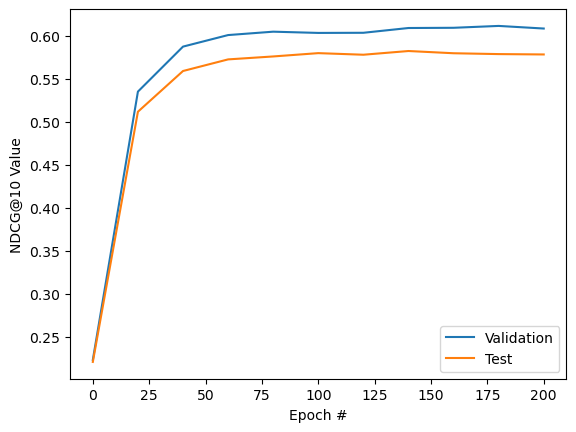

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(0,args.num_epochs,20), NDCG_score_valid_hist, label='Validation')
plt.plot(range(0,args.num_epochs,20), NDCG_score_test_hist,label='Test')
plt.xlabel("Epoch #")
plt.ylabel("NDCG@10 Value")
plt.legend()
plt.savefig("NDCG10.png")
plt.show()

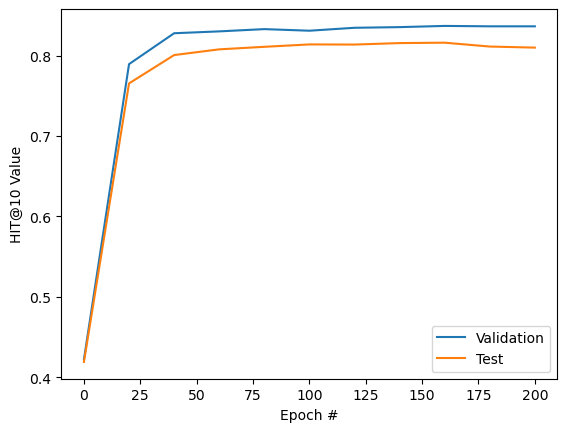

In [23]:
plt.plot(range(0,args.num_epochs,20), HIT_score_valid_hist, label='Validation')
plt.plot(range(0,args.num_epochs,20), HIT_score_test_hist,label='Test')
plt.xlabel("Epoch #")
plt.ylabel("HIT@10 Value")
plt.legend()
plt.savefig("HIT10.png")
plt.show()

The test result is NDCG@10: 0.5781, HR@10: 0.8101 on test set, which is compatible to the reported result in the papers (it is a little lower, probably because the embedding is not fit to the user and item number and other setup differences)

## Transfer Learning

Now that Pre-train is done, we can start transfer learning. The idea is to freeze the encoder part of the pretrained model - and only train the embedding layers. The trainable parameters are less than the full model


In [28]:
model.eval()
for p in model.parameters():
    p.requires_grad = True
for p in model.encoderlayers.parameters():
    p.requires_grad = False
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

1020300


### Wikipedia Dataset
The dataset is downloaded from the GitHub repo: https://github.com/pmixer/SASRec.pytorch/tree/master

In [26]:
data_name = 'wikipedia'#'lastfm_1k' # use '\t' as col_sep
dataset_tf = data_partition(data_name,' ')
user_train_tf, user_valid_tf, user_test_tf, usernum_tf, itemnum_tf = dataset_tf

In [27]:
# some statistics
num_steps = int(len(user_train_tf) / args.batch_size)
cc = 0.0
for u in user_train_tf:
    cc += len(user_train_tf[u])
print('%g Users and %g items' % (usernum_tf, itemnum_tf))
print('average sequence length: %.2f' % (cc / len(user_train_tf)))

8227 Users and 1000 items
average sequence length: 18.18


Redefine that sampler and optimizer, and also train for 200 epochs

In [38]:
sampler = WarpSampler(user_train_tf, usernum_tf, itemnum_tf, batch_size=args.batch_size, maxlen=args.maxlen,
                      threshold_user=args.threshold_user, threshold_item=args.threshold_item, n_workers=1)

In [30]:
bce_criterion = torch.nn.BCEWithLogitsLoss().to(args.device) # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.98))

In [32]:
T = 0.0
t0 = time.time()
epoch = 0
NDCG_score_valid_hist=[]
NDCG_score_test_hist=[]
HIT_score_valid_hist=[]
HIT_score_test_hist=[]
for epoch in range(args.num_epochs):
    if args.inference_only:
        break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        model.train() # enable model training
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(np.expand_dims(np.array(u),axis=-1)), np.array(seq), np.array(pos), np.array(neg)
        u, seq, pos, neg = torch.LongTensor(u).to(args.device), torch.LongTensor(seq).to(args.device), torch.LongTensor(pos).to(args.device), torch.LongTensor(neg).to(args.device)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        if args.device == 'cuda':
            indices = np.where(pos.cpu() != 0)
        else: indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        # for param in model.item_embedding_layer.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
        if step % 10 == 0:
            print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs for SASRec

    if epoch % 20 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        print('Evaluating', end='')
        t_valid = evaluate_valid(model, dataset_tf, args)

        t_test = evaluate(model, dataset_tf, args)

        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f), test (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1], t_test[0], t_test[1]))

        NDCG_score_valid_hist.append(t_valid[0])
        NDCG_score_test_hist.append(t_test[0])
        HIT_score_valid_hist.append(t_valid[1])
        HIT_score_test_hist.append(t_test[1])
        # f.write(str(t_valid) + ' ' + str(t_test) + '\n')
        # f.flush()
        t0 = time.time()
        model.train()


    if epoch == args.num_epochs-1:
        folder = args.dataset_tf + '_' + args.train_dir
        # fname = 'SSE_PT.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
        # fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
        fname = './SSE_PT_tf.pth'
        torch.save(model.state_dict(), fname)#, os.path.join(folder, fname))
        # f.close()
        sampler.close()
        print("Done")

loss in epoch 0 iteration 0: 1.071466326713562
loss in epoch 0 iteration 10: 1.033461093902588
loss in epoch 0 iteration 20: 1.0056207180023193
loss in epoch 0 iteration 30: 0.937404215335846
loss in epoch 0 iteration 40: 0.9105986952781677
Evaluating..............................................................................epoch:0, time: 1.604971(s), valid (NDCG@10: 0.7149, HR@10: 0.8014), test (NDCG@10: 0.6985, HR@10: 0.7863)
loss in epoch 1 iteration 0: 0.8986291885375977
loss in epoch 1 iteration 10: 0.856772780418396
loss in epoch 1 iteration 20: 1.00019109249115
loss in epoch 1 iteration 30: 0.8533534407615662
loss in epoch 1 iteration 40: 0.8529384136199951
loss in epoch 2 iteration 0: 0.8366269469261169
loss in epoch 2 iteration 10: 0.8032506704330444
loss in epoch 2 iteration 20: 0.7838171124458313
loss in epoch 2 iteration 30: 0.8177476525306702
loss in epoch 2 iteration 40: 0.7741386890411377
loss in epoch 3 iteration 0: 0.7539653778076172
loss in epoch 3 iteration 10: 0.

AttributeError: 'Namespace' object has no attribute 'dataset_tf'

In [33]:
if epoch == args.num_epochs-1:
    #folder = args.dataset + '_' + args.train_dir
    # fname = 'SSE_PT.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
    # fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
    fname = './SSE_PT_tf.pth'
    torch.save(model.state_dict(), fname)#, os.path.join(folder, fname))
    # f.close()
    sampler.close()
    print("Done")

Done


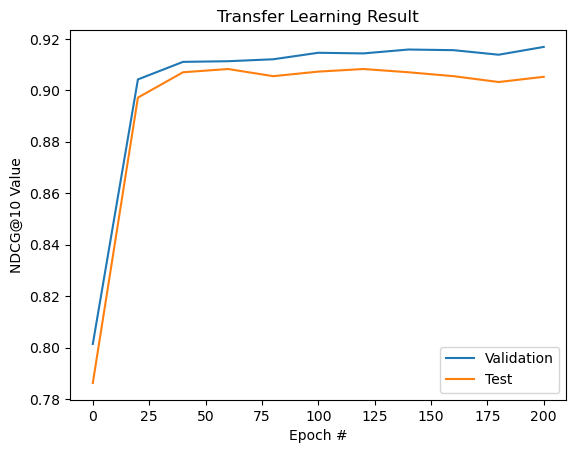

In [34]:
plt.plot(range(0,args.num_epochs,20), HIT_score_valid_hist, label='Validation')
plt.plot(range(0,args.num_epochs,20), HIT_score_test_hist,label='Test')
plt.xlabel("Epoch #")
plt.ylabel("NDCG@10 Value")
plt.legend()
plt.savefig("NDCG@10_tf.png")
plt.title('Transfer Learning Result')
plt.show()

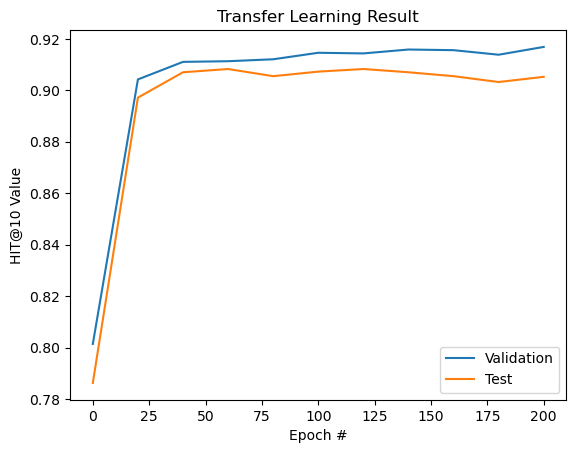

In [35]:
plt.plot(range(0,args.num_epochs,20), HIT_score_valid_hist, label='Validation')
plt.plot(range(0,args.num_epochs,20), HIT_score_test_hist,label='Test')
plt.xlabel("Epoch #")
plt.ylabel("HIT@10 Value")
plt.legend()
plt.savefig("HIT10_tf.png")
plt.title('Transfer Learning Result')
plt.show()

The result is NDCG@10: 0.8689, HR@10: 0.9053 which is pretty high. Also note that even at the beginning of the fine tuning phase the metrics are at a high level - maybe because that the sequence in this datasets are shorter so it is easier for the model which was learned from long sequence to predict this result.